## Generating Events

In [1]:
import numpy as np

# Event types
floatevent = 0

# Generate event of random size within range
# Return array representing event
def generate_event(event_size, rand_multiplier = 10):
    return np.array(rand_multiplier*np.random.rand(1, event_size), dtype='int16')

# Return array of n events of form (time, data)
# with times separated within dt range
# with data within size range
def generate_n_events(n, dt_min, dt_max, event_size):
    t = 0
    events = []
    for i in range(n):
        events.append((t, generate_event(event_size)))
        dt = dt_min + (np.random.random() * (dt_max - dt_min))
        t += dt
    return events

generate_n_events(3, 0.5, 0.8, 5000)

[(0, array([[9, 2, 9, ..., 3, 8, 7]], dtype=int16)),
 (0.6969973287619811, array([[6, 7, 8, ..., 5, 1, 1]], dtype=int16)),
 (1.4240516551661198, array([[0, 8, 2, ..., 9, 8, 7]], dtype=int16))]

## Simulation

In [2]:
import time
import h5py

# Run a simulation with the given parameters
# n_events is number of events to group together to write to hdf5
def run_sim(n, group_size, dt_min, dt_max, event_size, file="out.h5", libver = None):
    
    if libver:
        hf = h5py.File('data.h5', 'w', libver = libver)
    else:
        hf = h5py.File('data.h5', 'w')
    
    events = generate_n_events(n, dt_min, dt_max, event_size)
    
    group = []
    written = 0
    count = 0
    start = time.time()
    # Write the events to hdf5
    while count < n:
        now = time.time() - start

        # Next event has not fired yet
        if events[count][0] > now:
            # time.sleep is actually too sloww
            # time.sleep(0.001)
            continue
        
        # If the event has fired
        if group_size == 1:
            hf.create_dataset("event%d"%(count), data=events[count][1][0])
            written += 1
            count += 1
        elif group_size > 1:
            group.append(events[count][1][0])
            if len(group) >= group_size or count == n-1:
                hf.create_dataset("events%d"%(written), data=group)
                written += 1
                group = []
            count += 1

    hf.close()
    
    return time.time() - start

## Confirming data from hdf5

In [3]:
n_events = 5
print(run_sim(n_events, 2, 1, 2, 100), "s")

5.654011011123657 s


In [4]:
f = h5py.File('data.h5', 'r')
keys = list(f.keys())
print("Keys:", keys, "\n")

count = 0
for key in keys:
    data = np.array(f[key])
    print("Group %d size:"%count, data.shape)
    count += 1

print("\nFirst group:", list(f[keys[0]]))

f.close()

Keys: ['events0', 'events1', 'events2'] 

Group 0 size: (2, 100)
Group 1 size: (2, 100)
Group 2 size: (1, 100)

First group: [array([0, 3, 9, 3, 4, 6, 4, 9, 3, 4, 8, 5, 6, 2, 4, 2, 1, 5, 1, 0, 0, 6,
       2, 9, 1, 6, 3, 8, 9, 8, 2, 5, 2, 2, 5, 2, 4, 5, 3, 0, 7, 4, 9, 0,
       3, 1, 2, 2, 6, 4, 8, 1, 6, 8, 9, 3, 2, 4, 0, 9, 7, 8, 4, 7, 3, 2,
       3, 7, 9, 6, 8, 1, 8, 1, 0, 7, 0, 8, 4, 0, 0, 6, 0, 5, 4, 7, 2, 4,
       2, 7, 4, 4, 3, 8, 8, 5, 5, 5, 5, 9], dtype=int16), array([2, 2, 0, 5, 4, 8, 5, 9, 0, 1, 5, 6, 4, 1, 1, 1, 1, 1, 4, 2, 8, 3,
       3, 3, 3, 9, 7, 2, 6, 8, 0, 1, 3, 5, 9, 5, 0, 5, 4, 6, 5, 0, 1, 2,
       0, 3, 9, 0, 9, 7, 8, 7, 5, 5, 8, 8, 9, 3, 6, 2, 1, 5, 1, 9, 0, 8,
       4, 7, 6, 1, 6, 1, 7, 1, 6, 4, 4, 0, 0, 8, 9, 2, 9, 1, 7, 7, 3, 2,
       9, 1, 1, 0, 9, 1, 5, 4, 8, 8, 7, 7], dtype=int16)]


## Testing

In [5]:
from pylab import plot, xlabel, ylabel, title, show

def plot_results(group_sizes, run_times, event_size, n):
    bandwidths = (event_size * 16 * n) / np.array(run_times)
    bandwidths = bandwidths / 8E6 # b/s to MB/s
    
    plot(group_sizes, bandwidths, 'r.')
    title("Group Size vs Bandwidth")
    xlabel("Group size (events)")
    ylabel("Bandwidth (MB/s)")
    show()

### Does libver="latest" improve performance?

#### libver default

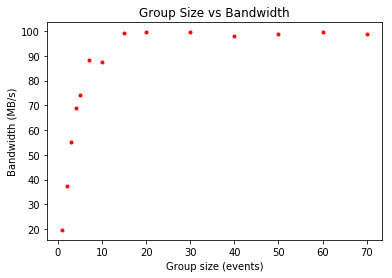

In [6]:
# Intitially test with constant dt
dt_min = 1/10000.0
dt_max = 1/10000.0
event_size = 5000

group_sizes = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70]

# Randomize order of group size
np.random.shuffle(group_sizes)

run_times = []

# 300000 events (~30 seconds)
n = 300000
for gs in group_sizes:
    run_times.append(run_sim(n, gs, dt_min, dt_max, event_size))

plot_results(group_sizes, run_times, event_size, n)

#### libver = "latest"

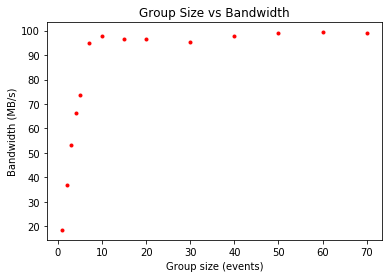

In [7]:
# Intitially test with constant dt
dt_min = 1/10000.0
dt_max = 1/10000.0
event_size = 5000

group_sizes = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 40, 50, 60, 70]

# Randomize order of group size
np.random.shuffle(group_sizes)

run_times = []

# 300000 events (~30 seconds)
n = 300000
for gs in group_sizes:
    run_times.append(run_sim(n, gs, dt_min, dt_max, event_size, libver="latest"))

plot_results(group_sizes, run_times, event_size, n)

## How fast can we get HDF5 to go?
To test this, we will implement a new simulation. Now, we will attempt to write a set number of events to disk as fast as possible (blast to disk). From this, we will determine the total size of the events written, and divide it by the time in order to determine throughput.

Also, notably, we are now using one dataset that is resized.

In [125]:
import h5py_cache as h5c

# Default chunk_cache_memsize is 1024*2*500 = 500MB
def run_sim_blast(n, event_size, chunk_shape, group_size=1000, file="out.h5", libver = None, chunk_cache_mem_size=1024*2*200):
    
    if libver:
        hf = h5c.File('data.h5', 'w', libver = libver, chunk_cache_mem_size=chunk_cache_mem_size)
    else:
        hf = h5c.File('data.h5', 'w', chunk_cache_mem_size=chunk_cache_mem_size)
    
    event = np.arange(event_size)
    
    shape = (1, event_size)
    maxshape = (None, event_size)
    # Now we are only using 1 dataset that is resized
    d = hf.create_dataset("all_events", shape=shape, maxshape = maxshape, chunks=chunk_shape)
    
    
    group = []
    start = time.time()
    
    # Write the events to hdf5
    for i in range(n):
        if i != 0 and i % group_size == 0:
            d.resize((i + group_size, event_size))
            d[i-group_size:i, :] = group
            group = []

        group.append(event)
    
    if len(group) > 0:
        d[i-len(group)+1:i+1, :] = group
    
    hf.close()
    
    runtime = time.time() - start
    throughput = n * event_size * 16 / runtime / 8E6
    return runtime, throughput

#### Confirming data from HDF5 

In [126]:
print(run_sim_blast(10, 5000, (20, 5000), libver = "latest", group_size = 5))

(0.0030999183654785156, 32.25891401322873)


In [127]:
f = h5py.File('data.h5', 'r')
keys = list(f.keys())
print("Keys:", keys, "\n")

for key in keys:
    data = np.array(f[key])
    print("Size:", data.shape)

print("DATA: ", list(f[keys[0]]))

f.close()

Keys: ['all_events'] 

Size: (10, 5000)
DATA:  [array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.997e+03, 4.998e+03,
       4.999e+03], dtype=float32), array([0.000e+00, 1.000e+00, 2.000

### Testing

#### Testing different group size

In [128]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 1)

print("Group size 1 throughput:", throughput, "MB/s")

Group size 1 throughput: 28.296173857171713 MB/s


In [129]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 10)

print("Group size 10 throughput:", throughput, "MB/s")

Group size 10 throughput: 178.60901934020038 MB/s


In [130]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 50)

print("Group size 50 throughput:", throughput, "MB/s")

Group size 50 throughput: 279.595531781955 MB/s


In [131]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 100)

print("Group size 100 throughput:", throughput, "MB/s")

Group size 100 throughput: 275.76783898148886 MB/s


In [132]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 300)

print("Group size 300 throughput:", throughput, "MB/s")

Group size 300 throughput: 294.5702157019126 MB/s


In [133]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 500)

print("Group size 500 throughput:", throughput, "MB/s")

Group size 500 throughput: 319.40401733002926 MB/s


In [134]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 1000)

print("Group size 1000 throughput:", throughput, "MB/s")

Group size 1000 throughput: 335.7505066244548 MB/s


In [135]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 1500)

print("Group size 1000 throughput:", throughput, "MB/s")

Group size 1000 throughput: 337.77057939964624 MB/s


In [136]:
runtime, throughput = run_sim_blast(300000, 5000, (20, 5000), libver = "latest", group_size = 10000)

print("Group size 1000 throughput:", throughput, "MB/s")

# is this poor performance due to slowdown with array appending?

Group size 1000 throughput: 176.386473189412 MB/s


#### Testing different chunk shapes

In [145]:
runtime, throughput = run_sim_blast(300000, 5000, (1, 5000), libver = "latest", group_size = 1500)

print("Chunk shape (1, 5000) throughput:", throughput, "MB/s")

Chunk shape (1, 5000) throughput: 90.10176594108519 MB/s


In [146]:
runtime, throughput = run_sim_blast(300000, 5000, (10, 5000), libver = "latest", group_size = 1500)

print("Chunk shape (10, 5000) throughput:", throughput, "MB/s")

Chunk shape (10, 5000) throughput: 259.3803830747087 MB/s


In [147]:
runtime, throughput = run_sim_blast(300000, 5000, (15, 5000), libver = "latest", group_size = 1500)

print("Chunk shape (15, 5000) throughput:", throughput, "MB/s")

Chunk shape (15, 5000) throughput: 303.97273130770236 MB/s


In [150]:
runtime, throughput = run_sim_blast(300000, 5000, (25, 5000), libver = "latest", group_size = 1500)

print("Chunk shape (25, 5000) throughput:", throughput, "MB/s")

Chunk shape (25, 5000) throughput: 300.3516165035619 MB/s


In [152]:
runtime, throughput = run_sim_blast(300000, 5000, (50, 5000), libver = "latest", group_size = 1500)

print("Chunk shape (50, 5000) throughput:", throughput, "MB/s")

Chunk shape (50, 5000) throughput: 293.0553432935738 MB/s
